**Yield Curve Modeling**

A yield curve is a graph that represents the relationship between interest rates (or yields) and the time to maturity of debt securities issued as a government bond

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import pandas as pd

In [41]:
Years1 = pd.read_csv('1-Year.csv')
Years10 = pd.read_csv('10-Year.csv')
Years30 = pd.read_csv('30-Year.csv')
Years19 = pd.read_csv('19-Year.csv')
Years5 = pd.read_csv('5-Year.csv')
Years2 = pd.read_csv('2-Year.csv')
Months3 = pd.read_csv('3-Months.csv')
Months6 = pd.read_csv('6-Months.csv')
Years3 = pd.read_csv('3-Year.csv')
Years7 = pd.read_csv('7-Year.csv')


In [42]:
Years2.shape, Years5.shape, Years10.shape, Years19.shape, Years30.shape, Months3.shape, Months6.shape, Years1.shape, Years3.shape, Years7.shape

((4267, 6),
 (4999, 6),
 (4999, 6),
 (4613, 6),
 (4522, 6),
 (4999, 6),
 (4999, 6),
 (4999, 6),
 (4999, 6),
 (4999, 6))

In [5]:
Years1.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Change %'], dtype='object')

In [52]:
# Rename the "Open" column to represent maturity
Months3.rename(columns={"Open": "3-Month"}, inplace=True)
Months6.rename(columns={"Open": "6-Months"}, inplace=True)
Years1.rename(columns={"Open": "1-Year"}, inplace=True)
Years2.rename(columns={"Open": "2-Year"}, inplace=True)
Years5.rename(columns={"Open": "5-Year"}, inplace=True)
Years10.rename(columns={"Open": "10-Year"}, inplace=True)
Years19.rename(columns={"Open": "19-Year"}, inplace=True)
Years30.rename(columns={"Open": "30-Year"}, inplace=True)
Years3.rename(columns={"Open": "3-Year"}, inplace=True)
Years7.rename(columns={"Open": "7-Year"}, inplace=True)

# Select only "Date" and renamed "Open" columns
Months3 = Months3[['Date', '3-Month']]
Months6 = Months6[['Date', '6-Months']]
Years1 = Years1[['Date', '1-Year']]
Years2 = Years2[['Date', '2-Year']]
Years5 = Years5[['Date', '5-Year']]
Years10 = Years10[['Date', '10-Year']]
Years19 = Years19[['Date', '19-Year']]
Years30 = Years30[['Date', '30-Year']]
Years3 = Years3[['Date', '3-Year']]
Years7 = Years7[['Date', '7-Year']]

# Merge all dataframes on "Date"
merged_df = Months3.merge(Months6, on='Date', how='outer') \
                   .merge(Years1, on='Date', how='outer') \
                   .merge(Years2, on='Date', how='outer') \
                   .merge(Years3, on='Date', how='outer') \
                   .merge(Years5, on='Date', how='outer') \
                   .merge(Years7, on='Date', how='outer') \
                   .merge(Years10, on='Date', how='outer') \
                   .merge(Years19, on='Date', how='outer') \
                   .merge(Years30, on='Date', how='outer')

merged_df.head()

,Date,3-Month,6-Months,1-Year,2-Year,3-Year,5-Year,7-Year,10-Year,19-Year,30-Year
0,01/01/1999,NaN,NaN,NaN,NaN,11.498,NaN,NaN,12.224,NaN,NaN
1,01/01/2001,NaN,NaN,9.992,NaN,10.149,10.376,10.561,10.803,NaN,NaN
2,01/01/2002,NaN,NaN,6.995,NaN,7.119,7.363,7.505,7.911,9.011,NaN
3,01/01/2003,5.48,5.50,5.699,NaN,5.602,5.713,5.876,6.032,6.439,NaN
4,01/01/2004,4.21,4.25,4.370,NaN,4.569,4.729,4.950,5.127,NaN,NaN


In [13]:
Months3.shape, Months6.shape, Years1.shape, Years2.shape, Years5.shape, Years10.shape, Years19.shape, Years30.shape

((21, 2), (21, 2), (20, 2), (21, 2), (21, 2), (21, 2), (20, 2), (21, 2))

In [53]:
merged_df.isna().sum()

,0
Date,0
3-Month,2078
6-Months,2078
1-Year,2078
2-Year,2810
3-Year,2078
5-Year,2078
7-Year,2078
10-Year,2078
19-Year,2464


In [56]:
yields = merged_df
yields = yields.dropna()
yields.shape

(2301, 11)

In [46]:
yields

,Date,3-Month,6-Months,1-Year,2-Year,5-Year,10-Year,19-Year,30-Year,3-Year,7-Year
7,01/01/2009,4.53,4.60,4.628,5.047,5.380,5.275,6.331,6.364,5.263,5.443
8,01/01/2010,3.60,4.10,5.098,5.539,7.241,7.695,8.209,8.337,6.368,7.429
9,01/01/2013,8.13,8.09,8.058,7.788,7.989,7.994,8.168,8.222,7.889,8.049
10,01/01/2014,8.49,8.80,8.550,8.665,8.948,8.844,9.259,9.269,8.544,9.077
11,01/01/2015,8.30,8.35,8.168,7.879,8.028,7.880,7.999,8.035,8.003,8.092
...,...,...,...,...,...,...,...,...,...,...,...
7066,12/31/2010,7.20,7.35,7.490,7.508,7.853,7.913,8.428,8.429,7.529,7.842
7067,12/31/2012,8.17,8.15,7.946,7.812,8.024,8.049,8.248,8.304,7.925,8.106
7068,12/31/2013,8.53,8.82,8.978,8.564,8.934,8.820,9.241,9.247,8.509,9.051
7069,12/31/2014,8.33,8.32,8.102,7.979,7.992,7.855,7.974,8.021,7.964,8.032


In [57]:
# Convert relevant columns in 'yields' DataFrame to numeric
for col in yields.columns[1:]:  # Skip the 'Date' column
    yields[col] = pd.to_numeric(yields[col], errors='coerce')

# Now calculate the standard deviation, excluding the 'Date' column
y_std = yields.drop(columns=['Date']).std() # Drop the 'Date' column before calculation
y_std

<ipython-input-57-fe020558114a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yields[col] = pd.to_numeric(yields[col], errors='coerce')


,0
3-Month,1.728243
6-Months,1.609452
1-Year,1.376639
2-Year,1.062141
3-Year,0.866171
5-Year,0.729818
7-Year,0.684420
10-Year,0.667521
19-Year,0.582742
30-Year,0.575756


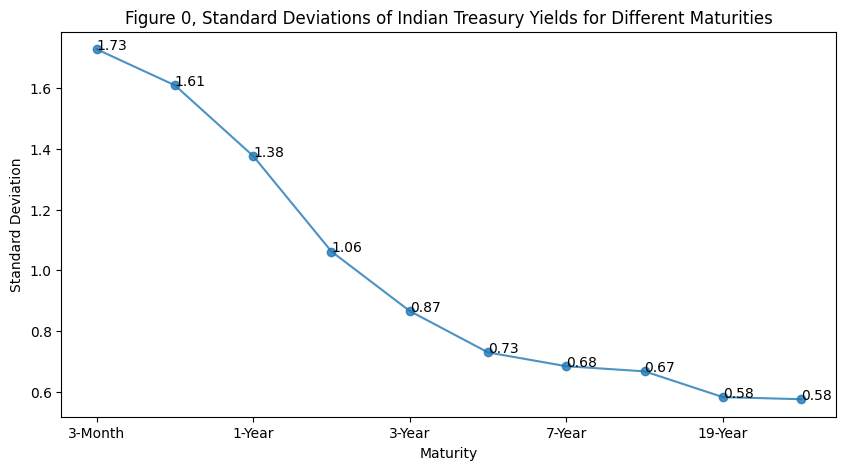

In [58]:
fig, ax = plt.subplots()
y_std.plot(figsize = (10,5),marker='o', title='Figure 0, Standard Deviations of Indian Treasury Yields for Different Maturities', alpha=0.8) # Plot standard deviations of yields of different maturies
plt.xlabel("Maturity")
plt.ylabel("Standard Deviation")
for i in range(len(y_std)):
    ax.annotate(str(round(y_std.iloc[i],2)),xy=(i,y_std.iloc[i]))
plt.show()

From the above graph, we see that the standard deviations of India Treasury bonds with short maturities are higher than the Indian Treasury bonds with longer maturities. The standard deviations for Treasury bonds with maturities of less than one year stay high above 1.38. Then, the standard deviations of Treasury bonds with maturities over one year decrease steadily.

In [59]:
# Convert 'Date' column to datetime objects
yields['Date'] = pd.to_datetime(yields['Date'])

# Set 'Date' column as the index
yields = yields.set_index('Date')

# Now the 'Date' column is the index and of datetime type
yields.head()

<ipython-input-59-65af576533b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yields['Date'] = pd.to_datetime(yields['Date'])


,3-Month,6-Months,1-Year,2-Year,3-Year,5-Year,7-Year,10-Year,19-Year,30-Year
Date,,,,,,,,,,
2009-01-01,4.53,4.60,4.628,5.047,5.263,5.380,5.443,5.275,6.331,6.364
2010-01-01,3.60,4.10,5.098,5.539,6.368,7.241,7.429,7.695,8.209,8.337
2013-01-01,8.13,8.09,8.058,7.788,7.889,7.989,8.049,7.994,8.168,8.222
2014-01-01,8.49,8.80,8.550,8.665,8.544,8.948,9.077,8.844,9.259,9.269
2015-01-01,8.30,8.35,8.168,7.879,8.003,8.028,8.092,7.880,7.999,8.035


Figure 3


<ipython-input-60-b6ebfc6983c3>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])


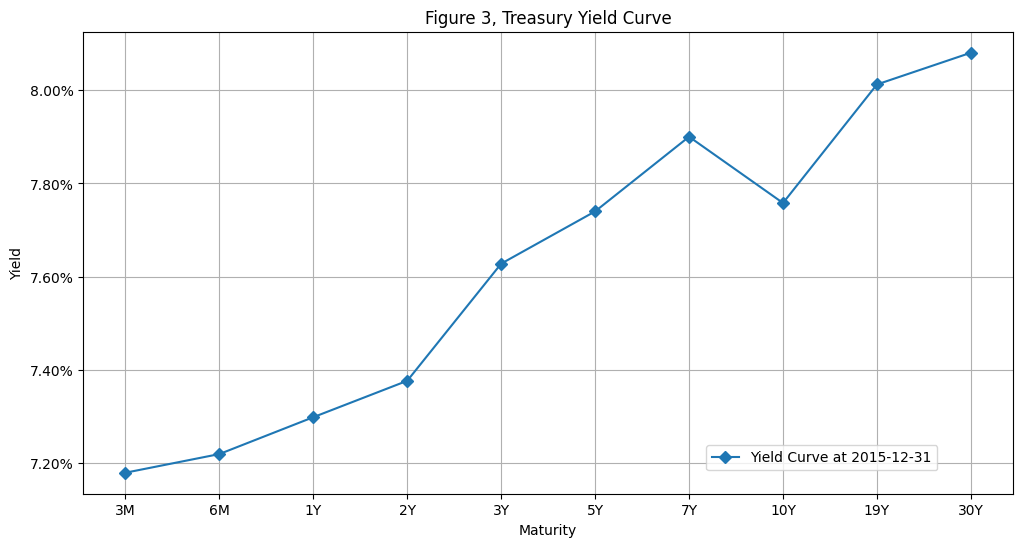

In [60]:
def plot_yield_curve(date, fig_n):
    maturities = ['3M', '6M', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '19Y', '30Y'] # Maturities
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(maturities, yields.loc[date], marker='D', label='Yield Curve at ' + date)

    ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])
    ax.set_xticks(range(len(maturities)))
    ax.set_xticklabels(maturities)

    # Add labels and title
    ax.set_xlabel('Maturity')
    ax.set_ylabel('Yield')
    ax.set_title(fig_n+'Treasury Yield Curve')


    fig.legend(loc = [0.69, 0.14])

    # Show the plot
    plt.grid(True)
    plt.show()

print("Figure 3")
plot_yield_curve('2015-12-31','Figure 3, ')


In [62]:
!pip install nelson_siegel_svensson

In [64]:
# Import the packages for fitting NS model
from nelson_siegel_svensson.calibrate import calibrate_ns_ols
import numpy as np
# Create maturity and yield variables in array form
t = np.array([0.25,0.5,1,2,3,5,7,10,19,30])
y = np.array(yields.loc["2015-12-31"])

In [65]:
# Fit an NS model for yields from 2020-01-10
curve, status = calibrate_ns_ols(t, y, tau0=1.0)  # starting value of 1.0 for the optimization of tau
assert status.success
print(curve)

NelsonSiegelCurve(beta0=8.088357875766684, beta1=-0.9175496985014922, beta2=-0.845557239000973, tau=1.0129554608953)


Text(0.5, 1.0, 'Figure 4, NS Model Result')

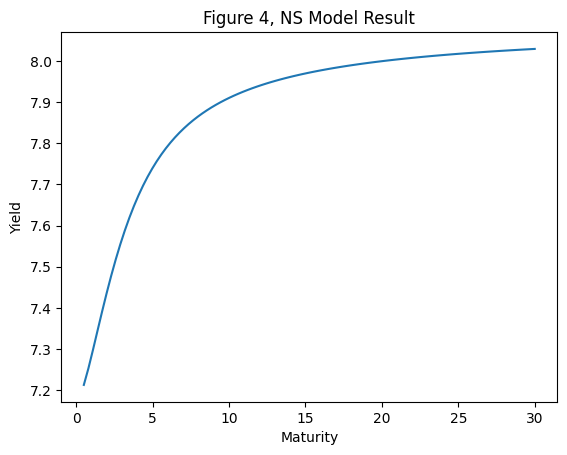

In [66]:
y_hat = curve
t_hat = np.linspace(0.5,30,100)
plt.plot(t_hat, y_hat(t_hat))
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Figure 4, NS Model Result")

From the above Figure 4, we can see the estimated yield curve is a pretty good fit of the curve chart we drew in the previous section.

<ipython-input-60-b6ebfc6983c3>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:.2f}%'.format(y) for y in ax.get_yticks()])


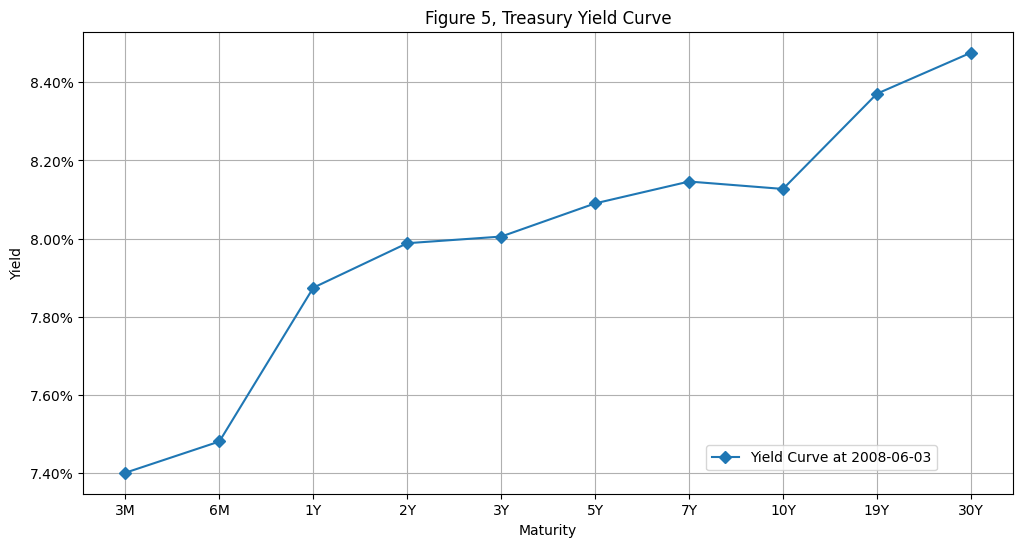

In [68]:
plot_yield_curve('2008-06-03', 'Figure 5, ')

In [69]:
y = np.array(yields.loc["2008-06-03"])
curve, status = calibrate_ns_ols(t, y, tau0=0.5)  # starting value of 0.5 for the optimization of tau
assert status.success
print(curve)

NelsonSiegelCurve(beta0=8.34212974984723, beta1=-1.0830336243287437, beta2=-2.1655025005395956e-06, tau=0.7873783661896936)


Text(0.5, 1.0, 'Figure 6, NS Model Result')

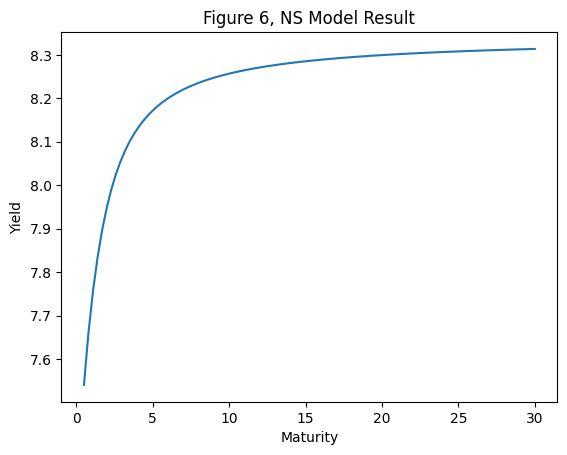

In [70]:
y_hat = curve
t_hat = np.linspace(0.5,30,100)
plt.plot(t_hat, y_hat(t_hat))
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.title("Figure 6, NS Model Result")

In [67]:
# Find the highest and lowest dates
highest_date = yields.index.max()
lowest_date = yields.index.min()

print(f"Highest Date: {highest_date}")
print(f"Lowest Date: {lowest_date}")

Highest Date: 2017-01-10 00:00:00
Lowest Date: 2008-01-02 00:00:00


**Cubic Spline**

In [71]:
yields.loc["2015-12-31"]

,2015-12-31
3-Month,7.180
6-Months,7.220
1-Year,7.299
2-Year,7.377
3-Year,7.628
5-Year,7.740
7-Year,7.900
10-Year,7.758
19-Year,8.012
30-Year,8.080


In [74]:
maturities = np.array([2,5,10,30])
ys = np.array([7.377,7.740,7.758,8.080])

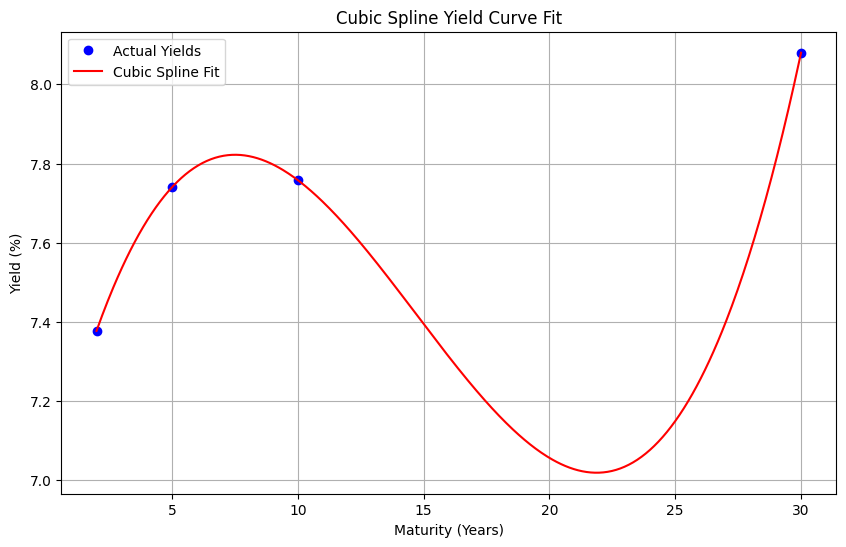

In [76]:
# Fit cubic spline
cs = CubicSpline(maturities, ys)

# Create a dense grid of maturities for smooth plotting
dense_maturities = np.linspace(min(maturities), max(maturities), 500)
fitted_yields = cs(dense_maturities)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(maturities, ys, 'o', label="Actual Yields", color='blue')
plt.plot(dense_maturities, fitted_yields, '-', label="Cubic Spline Fit", color='red')
plt.title("Cubic Spline Yield Curve Fit")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid()
plt.show()

The resulting yield curve is as shown above. The blue dots represent the actual yields, while the red curve shows the smooth cubic spline interpolation

**e. Compare the models in terms of 1) fit and 2) interpretation**

**Fit**

The fit quality can be evaluated visually and quantitatively by comparing how well each model replicates the given data points and their smoothness for extrapolated maturities.
Cubic spline provides exact fit to the data points because it interpolates them while Nelson-Siegel generates a smooth and parsimonous yield curve that balances fitting accuracy and interpretability.

As much as, Cubic spline provide a perfect fit for the data, it overfits even if the data has noise. On the other hand, a shortcoming of Nelson-Niegel, seems to be generalizing, although it may not perfectly fit the data especially, in the case of irregularities in the data.

**interpretation**

Cubic spline yield curve is purposefully for mathematical interpretation, uses piecewise cubic polynomials to fit the data, yet do not offer any insights into bond market dynamics. For Nelson-Niegel, the parameters **$(\beta_0, \beta_1, \beta_2, \text{and } \lambda)$** where:


*   $β
0
​$
 : Represents the long-term component of the yield curve.
* $𝛽
1$
​
 : Captures the slope of the yield curve - short-term against long-term rates.
* $𝛽
2$
​
 : Describes the curvature, projecting the medium-term dynamics.
* $𝜆$: Controls the rate of decay for the slope and curvature components.



**g. The Ethics of smoothing data**

The ethics of smoothing data, including using models like the Nelson-Siegel framework to smooth the yield curve, depend on intent, transparency, and impact. The Nelson-Siegel model in many cases is used for analyzing yield curves to simplify and interpret interest rate trends. It provides a structured, parsimonious representation of the yield curve without overfitting the data. It becomes unethical when it is used to intentionally hide critical information, such as market irregularities or risks.